In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Simulation parameters

In [2]:
# --- dBm <-> Watts 변환 함수 ---
def dbm_to_watts(dbm):
    return (10**(dbm / 10)) / 1000

def watts_to_dbm(watts):
    epsilon = 1e-30     # 0에 가까운 값 방지를 위해 작은 값(epsilon) 처리
    return 10 * np.log10((watts + epsilon) * 1000)

# 1. 송신 전력 (Pt) (단위: dBm)
p_t_dbm = 10.0
p_t_watts = dbm_to_watts(p_t_dbm)

# 2. 시스템 주파수 (Carrier Frequency) (단위: Hz)
f_c = 3.5e9
c = 3.0e8    # 빛의 속도 (m/s)
lambda_wave = c / f_c


# 3. 송신(Tx) 및 수신(Rx) 경로의 수
L_t = 3
L_r = 10

# 4. 시각화를 위한 수신 영역 (Rx Region) 설정
A_normalized = 2.0
A = A_normalized * lambda_wave
grid_points = 200  # 시각화 그리드 해상도

# 5. epoch
epochs = 1000

# --- 시뮬레이션용 고정 파라미터 ---
t_pos_fixed = np.array([0.0, 0.0])

print(f"--- 시뮬레이션 파라미터 ---")
print(f"송신 전력 (P_t): {p_t_dbm:.2f} dBm (={p_t_watts:.4f} W)")
print(f"주파수 (f_c): {f_c/1e9:.2f} GHz")
print(f"파장 (lambda): {lambda_wave:.4f} m")
print(f"Tx 경로 수 (L_t): {L_t}")
print(f"Rx 경로 수 (L_r): {L_r}")
print(f"수신 영역 (A): {A_normalized} lambda (={A:.4f} m)")

--- 시뮬레이션 파라미터 ---
송신 전력 (P_t): 10.00 dBm (=0.0100 W)
주파수 (f_c): 3.50 GHz
파장 (lambda): 0.0857 m
Tx 경로 수 (L_t): 3
Rx 경로 수 (L_r): 10
수신 영역 (A): 2.0 lambda (=0.1714 m)


Channel setting

In [3]:
# 1. 송신(Tx) 측 AoDs (Angles of Departure)
# [theta_t,j, phi_t,j] (L_t 개)
np.random.seed(42)  # 재현성을 위한 시드 고정
theta_t = np.random.uniform(-np.pi/2, np.pi/2, L_t)
phi_t = np.random.uniform(-np.pi/2, np.pi/2, L_t)

# 2. 수신(Rx) 측 AoAs (Angles of Arrival)
# [theta_r,i, phi_r,i] (L_r 개)
theta_r = np.random.uniform(-np.pi/2, np.pi/2, L_r)
phi_r = np.random.uniform(-np.pi/2, np.pi/2, L_r)

# 3. 경로 응답 행렬 (Path-Response Matrix, Sigma)
sigma_matrix = (np.random.randn(L_r, L_t) + 1j * np.random.randn(L_r, L_t)) / np.sqrt(2)

# --- 파라미터 확인 ---
print("--- 채널 환경 파라미터 (랜덤 생성) ---")
print(f"Tx AoDs (theta_t):\n {theta_t}")
print(f"Tx AoDs (phi_t):\n {phi_t}")
print(f"Rx AoAs (theta_r):\n {theta_r}")
print(f"Rx AoAs (phi_r):\n {phi_r}")
print(f"Sigma Matrix (Shape: {sigma_matrix.shape}):\n {sigma_matrix}")

--- 채널 환경 파라미터 (랜덤 생성) ---
Tx AoDs (theta_t):
 [-0.39414384  1.41596075  0.72883046]
Tx AoDs (phi_t):
 [ 0.30994477 -1.08064931 -1.08072509]
Rx AoAs (theta_r):
 [-1.38832128  1.15037629  0.31766218  0.65367928 -1.50612823  1.47626534
  1.04439936 -0.90371334 -0.99957635 -0.99461407]
Rx AoAs (phi_r):
 [-0.61499113  0.07777462 -0.21380103 -0.655873    0.35139623 -1.13256344
 -0.65299685 -0.41983665 -0.13801021  0.89590671]
Sigma Matrix (Shape: (10, 3)):
 [[ 0.04774965-0.47865614j -1.0074491 +0.43252045j -0.38493672+0.72902675j]
 [ 0.07843412+0.65851449j -0.81387536-0.5934164j   0.26565862-0.21864617j]
 [-0.42471569+0.23423862j -0.20625863+0.68981457j -0.42547083-0.33882735j]
 [ 1.30975846-0.13128072j -0.00954398-0.78229696j -0.74791457-0.84584582j]
 [ 0.58162709+0.57454252j -0.86326682+0.95900652j  0.14768886-0.05091885j]
 [-1.38569603+0.70960492j -0.93916936+0.25571529j  0.13920191-0.45616855j]
 [ 0.52217473+0.25554528j  0.12117567+1.08755609j -0.08177568-0.02533284j]
 [-0.21291246+1.10

Functions

In [4]:
def calculate_g_t(t_pos, theta_t, phi_t, lambda_wave):
    """
    t_pos (np.array): 송신 안테나 위치 [x_t, y_t] (크기 2)
    theta_t (np.array): Tx 경로별 elevation AoD (크기 L_t)
    phi_t (np.array): Tx 경로별 azimuth AoD (크기 L_t)
    """
    x_t, y_t = t_pos
    L_t = len(theta_t)
    g_t = np.zeros(L_t, dtype=complex)

    for j in range(L_t):
        rho_t_j = x_t * np.cos(theta_t[j]) * np.sin(phi_t[j]) + \
                  y_t * np.sin(theta_t[j])

        # g(t)의 j번째 요소 계산
        g_t[j] = np.exp(1j * 2 * np.pi * rho_t_j / lambda_wave)

    return g_t

def calculate_f_r(r_pos, theta_r, phi_r, lambda_wave):
    """
    r_pos (np.array): 수신 안테나 위치 [x_r, y_r] (크기 2)
    theta_r (np.array): Rx 경로별 elevation AoA (크기 L_r)
    phi_r (np.array): Rx 경로별 azimuth AoA (크기 L_r)
    """
    x_r, y_r = r_pos
    L_r = len(theta_r)
    f_r = np.zeros(L_r, dtype=complex)

    for i in range(L_r):
        rho_r_i = x_r * np.cos(theta_r[i]) * np.sin(phi_r[i]) + \
                  y_r * np.sin(theta_r[i])

        f_r[i] = np.exp(1j * 2 * np.pi * rho_r_i / lambda_wave)

    return f_r

def calculate_channel_coefficient(g_t, f_r, sigma_matrix):
    """
    채널 계수 h(t,r)을 계산
    (논문 수식 (6): h(t,r) = f(r)^H * Sigma * g(t))

    sigma_matrix (np.array): Sigma 행렬 (크기 L_r, L_t)
    """
    f_r_hermitian = f_r.conj().T

    g_t_col = g_t.reshape(-1, 1)
    f_r_row_h = f_r_hermitian.reshape(1, -1)

    h = (f_r_row_h @ sigma_matrix @ g_t_col).item()

    return h

# --- 채널 이득 및 최종 전력 계산 함수 ---

def calculate_channel_gain(h_tr):
    # 채널 순수 이득 (Channel Gain) |h(t,r)|^2 계산
    gain = np.abs(h_tr)**2
    return gain

def calculate_received_power(h_tr, p_t_watts):
    # 1. 채널 전력 이득 (선형)
    channel_power_gain = np.abs(h_tr)**2

    # 2. 수신 신호 전력 (선형, Watts)
    received_power_watts = channel_power_gain * p_t_watts

    # 3. dBm으로 변환하여 반환
    received_power = watts_to_dbm(received_power_watts)

    return received_power

Received power simulation

In [5]:
def run_single_simulation_epoch(L_t, L_r, lambda_wave, A, grid_points, p_t_watts, t_pos_fixed):
    """
    단 1회의 시뮬레이션(에포크)을 실행하고 MA와 FPA의 성능 이득(dB)을 반환합니다.
    이 함수는 매번 새로운 랜덤 채널을 생성합니다.
    """

    # --- 1. 새 랜덤 채널 환경 생성 ---
    # (이전 Cell 3 로직)
    theta_t = np.random.uniform(-np.pi/2, np.pi/2, L_t)
    phi_t = np.random.uniform(-np.pi/2, np.pi/2, L_t)
    theta_r = np.random.uniform(-np.pi/2, np.pi/2, L_r)
    phi_r = np.random.uniform(-np.pi/2, np.pi/2, L_r)
    sigma_matrix = (np.random.randn(L_r, L_t) + 1j * np.random.randn(L_r, L_t)) / np.sqrt(2)

    # --- 2. MA 성능 계산 (2D 맵 전체 탐색) ---
    g_t_fixed = calculate_g_t(t_pos_fixed, theta_t, phi_t, lambda_wave)

    half_A = A / 2
    x_r_vals = np.linspace(-half_A, half_A, grid_points)
    y_r_vals = np.linspace(-half_A, half_A, grid_points)

    received_power_map = np.zeros((grid_points, grid_points))

    for i in range(grid_points):
        for j in range(grid_points):
            r_current = np.array([x_r_vals[i], y_r_vals[j]])
            f_r_current = calculate_f_r(r_current, theta_r, phi_r, lambda_wave)
            h_tr_current = calculate_channel_coefficient(g_t_fixed, f_r_current, sigma_matrix)
            received_power_map[j, i] = calculate_received_power(h_tr_current, p_t_watts)

    power_ma_max = np.max(received_power_map)

    # --- 3. FPA 성능 계산 (랜덤 위치 1곳) ---
    fpa_pos_x = np.random.uniform(-half_A, half_A)
    fpa_pos_y = np.random.uniform(-half_A, half_A)
    fpa_pos = np.array([fpa_pos_x, fpa_pos_y])

    f_r_fpa = calculate_f_r(fpa_pos, theta_r, phi_r, lambda_wave)
    h_tr_fpa = calculate_channel_coefficient(g_t_fixed, f_r_fpa, sigma_matrix)
    power_fpa = calculate_received_power(h_tr_fpa, p_t_watts)

    # --- 4. 성능 이득 (Gain) 반환 ---
    gain_db = power_ma_max - power_fpa

    # 맵과 FPA 위치도 함께 반환 (시각화용)
    return gain_db, received_power_map, fpa_pos, power_fpa

Epoch function

In [6]:
print(f"--- {epochs}회 에포크(epoch)의 평균 이득 계산 시작 ---")
print(f"(L_t={L_t}, L_r={L_r})")

all_gains_db = []

# tqdm 라이브러리 대신 10% 단위로 진행 상황 출력
print_interval = max(1, epochs // 10)

for epoch in range(epochs):
    # 1. 단일 시뮬레이션 실행
    gain_db, _, _, _ = run_single_simulation_epoch(
        L_t, L_r, lambda_wave, A, grid_points, p_t_watts, t_pos_fixed
    )

    # 2. 결과 저장
    all_gains_db.append(gain_db)

    # 3. 진행 상황 출력
    if (epoch + 1) % print_interval == 0 or epoch == epochs - 1:
        print(f"  ... Epoch {epoch + 1}/{epochs} 완료 (현재 평균: {np.mean(all_gains_db):.2f} dB)")

# --- 최종 평균 계산 ---
average_gain = np.mean(all_gains_db)

print(f"\n--- 최종 결과 (L_t={L_t}, L_r={L_r}) ---")
print(f"총 {epochs}회 실행 평균 이득 (MA Gain): {average_gain:.2f} dB")

--- 1000회 에포크(epoch)의 평균 이득 계산 시작 ---
(L_t=3, L_r=10)
  ... Epoch 100/1000 완료 (현재 평균: 8.24 dB)
  ... Epoch 200/1000 완료 (현재 평균: 8.36 dB)
  ... Epoch 300/1000 완료 (현재 평균: 8.28 dB)
  ... Epoch 400/1000 완료 (현재 평균: 8.30 dB)
  ... Epoch 500/1000 완료 (현재 평균: 8.24 dB)
  ... Epoch 600/1000 완료 (현재 평균: 8.11 dB)
  ... Epoch 700/1000 완료 (현재 평균: 8.26 dB)
  ... Epoch 800/1000 완료 (현재 평균: 8.30 dB)
  ... Epoch 900/1000 완료 (현재 평균: 8.30 dB)
  ... Epoch 1000/1000 완료 (현재 평균: 8.30 dB)

--- 최종 결과 (L_t=3, L_r=10) ---
총 1000회 실행 평균 이득 (MA Gain): 8.30 dB


Simulation result visualization

샘플 맵 1개를 생성하여 시각화합니다...


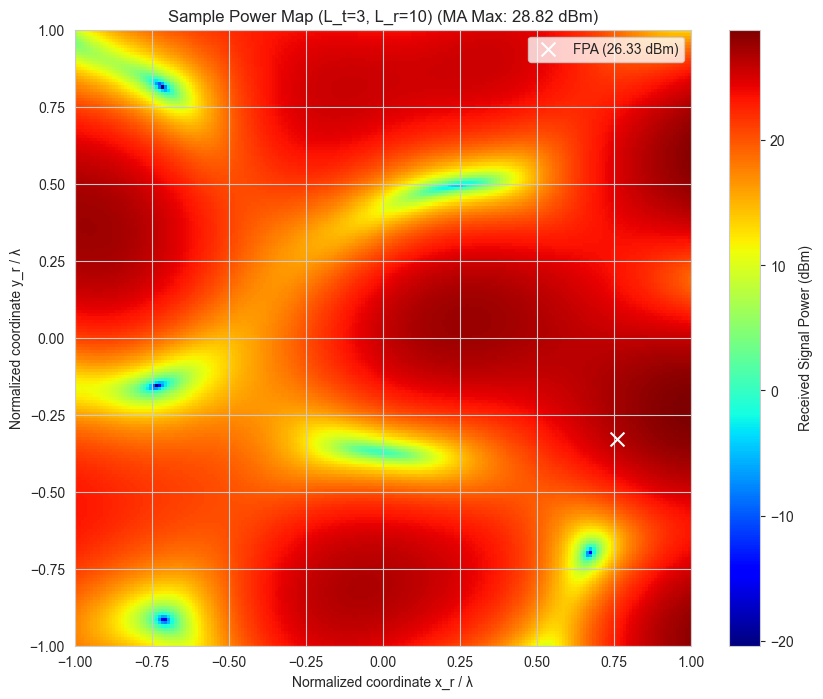

샘플 MA 이득: 2.49 dB


In [7]:
# --- 평균 계산 후, 맵 샘플 1개 시각화 ---
# (메인 루프에서 평균을 계산하느라 맵을 그리지 않았으므로,
#  궁금할 경우 이 셀을 실행하여 샘플 맵 1개를 볼 수 있습니다.)

print("샘플 맵 1개를 생성하여 시각화합니다...")

# 마지막 에포크의 맵을 생성하기 위해 함수를 한 번 더 호출
# (이 맵은 평균 계산에 포함되지 않은 새 랜덤 맵입니다.)
gain_sample, map_sample, fpa_pos_sample, power_fpa_sample = run_single_simulation_epoch(
    L_t, L_r, lambda_wave, A, grid_points, p_t_watts, t_pos_fixed
)
power_ma_sample = np.max(map_sample)

# --- 시각화 ---
extent = [-A_normalized/2, A_normalized/2, -A_normalized/2, A_normalized/2]
plt.figure(figsize=(10, 8))
im = plt.imshow(map_sample,
                extent=extent,
                origin='lower',
                aspect='equal',
                cmap='jet')

# FPA 랜덤 위치 표시 (하얀색 'x' 마커)
fpa_x_norm = fpa_pos_sample[0] / lambda_wave
fpa_y_norm = fpa_pos_sample[1] / lambda_wave
plt.scatter([fpa_x_norm], [fpa_y_norm], c='white', marker='x', s=100, label=f'FPA ({power_fpa_sample:.2f} dBm)')

plt.colorbar(im, label='Received Signal Power (dBm)')
plt.xlabel('Normalized coordinate x_r / λ')
plt.ylabel('Normalized coordinate y_r / λ')
plt.title(f'Sample Power Map (L_t={L_t}, L_r={L_r}) (MA Max: {power_ma_sample:.2f} dBm)')
plt.legend()
plt.show()

print(f"샘플 MA 이득: {gain_sample:.2f} dB")
